In [1]:
# Make sure torch version is cu118
!pip show torch

Name: torch
Version: 2.1.0+cu118
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, fsspec, jinja2, networkx, sympy, triton, typing-extensions
Required-by: accelerate, fastai, torchaudio, torchdata, torchtext, torchvision


In [2]:
!pip install -U accelerate
!pip install -U transformers

In [3]:
#!pip uninstall torch

Found existing installation: torch 2.1.0+cu118
Uninstalling torch-2.1.0+cu118:
  Would remove:
    /usr/local/bin/convert-caffe2-to-onnx
    /usr/local/bin/convert-onnx-to-caffe2
    /usr/local/bin/torchrun
    /usr/local/lib/python3.10/dist-packages/functorch/*
    /usr/local/lib/python3.10/dist-packages/nvfuser/*
    /usr/local/lib/python3.10/dist-packages/torch-2.1.0+cu118.dist-info/*
    /usr/local/lib/python3.10/dist-packages/torch/*
    /usr/local/lib/python3.10/dist-packages/torchgen/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.10/dist-packages/torch/lib/libcublas.so.12
    /usr/local/lib/python3.10/dist-packages/torch/lib/libcublasLt.so.12
    /usr/local/lib/python3.10/dist-packages/torch/lib/libcudart-9335f6a2.so.12
    /usr/local/lib/python3.10/dist-packages/torch/lib/libnvrtc-b51b459d.so.12
    /usr/local/lib/python3.10/dist-packages/torch/lib/libnvrtc-builtins.so.12.1
Proceed (Y/n)?   ERROR: Operation cancelled by user


In [4]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [7]:
import numpy as np
import pandas as pd
import torch
import string
import torchtext
from torchtext.datasets import IMDB
from torchtext.data.functional import to_map_style_dataset, sentencepiece_tokenizer
from torch.utils.data import DataLoader, TensorDataset
import nltk
from nltk.corpus import wordnet, stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from concurrent.futures import ProcessPoolExecutor
from functools import partial
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import re
from gensim.models import Word2Vec
from nltk.corpus import sentiwordnet as swn
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import matplotlib.pyplot as plt
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification


nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('sentiwordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


True

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


LOADING DATASET

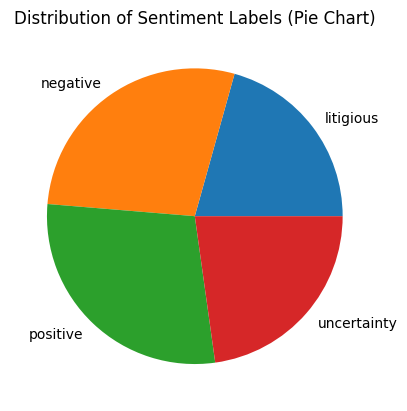

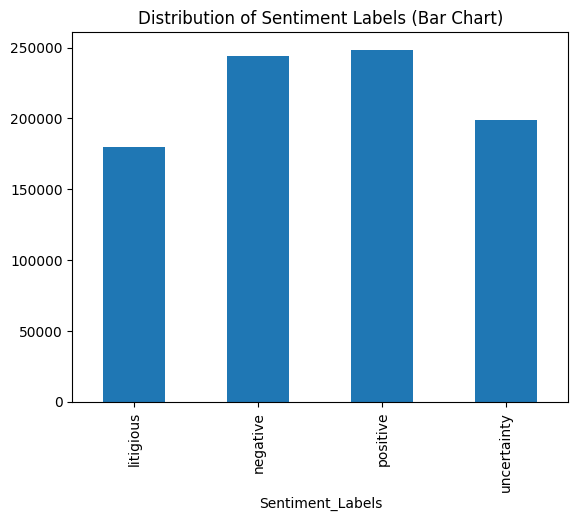

In [9]:
# Filter only English tweets
# Convert all columns to string type
# Drop all rows with any NaN and NaT values
UnC_Data = pd.read_csv('/content/drive/MyDrive/FYP_Colab_Notebooks/Dataset/dataset.csv', low_memory=False).query('Language == "en"').astype(str).dropna()

# Only keep the text and label columns
UnC_Data = UnC_Data[['Text', 'Label']]

# Rename the "Label" column as "sentiment labels"
UnC_Data = UnC_Data.rename(columns={'Label': 'Sentiment_Labels'})

# Visualize the distribution of the labels - Pie Chart
UnC_Data.groupby(['Sentiment_Labels']).size().plot.pie()
plt.title('Distribution of Sentiment Labels (Pie Chart)')
plt.show()

print(" ")

# Visualize the distribution of the labels - Bar Chart
UnC_Data.groupby(['Sentiment_Labels']).size().plot.bar()
plt.title('Distribution of Sentiment Labels (Bar Chart)')
plt.show()

DATA PREPROCESSING

In [10]:
import re
import nltk
from nltk.corpus import stopwords

# Pre-compiling regular expressions
emoji_pattern = re.compile("["
                          u"\U0001F600-\U0001F64F"
                          u"\U0001F300-\U0001F5FF"
                          u"\U0001F680-\U0001F6FF"
                          u"\U0001F1E0-\U0001F1FF"
                          u"\U00002702-\U000027B0"
                          u"\U000024C2-\U0001F251"
                          "]+", flags=re.UNICODE)

stop_words = set(stopwords.words('english'))
lemmatizer = nltk.WordNetLemmatizer()

def clean_and_preprocess(tweet):
    if not isinstance(tweet, str):
        return ""

    # Combine regular expressions
    temp = re.sub(r'http\S+|@\S+|#|\[.*?\]|[()!?]', ' ', tweet.lower())
    temp = re.sub("[^a-z0-9\s]", " ", temp)

    # Tokenization and Lemmatization (NLTK library) using list comprehension
    words = [lemmatizer.lemmatize(word) for word in re.findall(r'\b\w+\b', temp) if word not in stop_words]

    # Join the list of words back into a sentence
    processed_sentence = " ".join(words)

    return processed_sentence

# Apply the clean_and_preprocess function to the "Text" column
C_Data = UnC_Data.copy()
C_Data['Text'] = C_Data['Text'].apply(clean_and_preprocess)

In [11]:
C_Data.head(5)

,Text,Sentiment_Labels
0,testimony evidence court law state federal mus...,litigious
2,flagstar bank discloses data breach impacted 1...,litigious
3,rwanda set host headquarters united nation dev...,positive
4,oops typed name incorrectly today brave witnes...,litigious
5,suck since focused nature aspect thing environ...,negative


In [12]:
# Map the labels to numerical values
label_mapping = {'positive': 0, 'negative': 1, 'uncertainty': 2, 'litigious': 3}

# Add a new column "Numerical_Labels" to the dataset
C_Data['Numerical_Labels'] = C_Data['Sentiment_Labels'].map(label_mapping)

# Alternatively, if you want to keep both columns, you can use the following:
C_Data['Numerical_Labels'] = C_Data['Sentiment_Labels'].map(label_mapping).astype('int')

# Set the maximum column width to a larger value
pd.set_option('display.max_colwidth', 1000)
C_Data.head(5)

,Text,Sentiment_Labels,Numerical_Labels
0,testimony evidence court law state federal must stand cross examination,litigious,3
2,flagstar bank discloses data breach impacted 1 5 million individual cybersecurity,litigious,3
3,rwanda set host headquarters united nation development programme undp new innovation financing facility find sovereigngroup sovereignafrica undp rwanda,positive,0
4,oops typed name incorrectly today brave witness cassidyhutchinson 6 premeditatedviolence 7 probaby witnesstamperig forget markmeadows requesting pardon trumpknew trumpcapitolcoupattack capitolcoupattempt neverforgetjanuary6th neverforgetjan6th,litigious,3
5,suck since focused nature aspect thing environmental problem root social economic amp political issue simply recycling using renewable energy like fixing top floor building unsteady foundation,negative,1


In [13]:
# Save the preprocessed dataset to a CSV file for easier access
C_Data.to_csv('C_Data.csv', index=False)

In [14]:
# Adding the labels to a list to map ID to label and label to ID
labels = C_Data['Sentiment_Labels'].unique().tolist()
labels = [s.strip() for s in labels ]

label_count = len(labels)
label_count

4

In [15]:
# Update label IDs to start from 1
id2label = {id: label for id, label in enumerate(labels)}
label2id = {label: id for id, label in enumerate(labels)}

# Print the ID to label and label to ID mappings
print(id2label)
print(label2id)

{0: 'litigious', 1: 'positive', 2: 'negative', 3: 'uncertainty'}
{'litigious': 0, 'positive': 1, 'negative': 2, 'uncertainty': 3}


In [16]:
# Setting DistilBERT tokenizer as 'tokenizer'
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english", max_length=128)

# Set model to DistilBERTForSequenceClassification
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english", max_length=128, num_labels=label_count, id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model 

DATA SPLITTING

In [17]:
# labels = C_Data['Numerical_Labels']

# Split the dataset into train, test, and validation sets (8:1:1)
train_data, test_data = train_test_split(C_Data, test_size=0.2, random_state=42)
test_data, val_data = train_test_split(test_data, test_size=0.5, random_state=42)

# Save the train, test, and validation datasets to CSV files
train_data.to_csv("train_data.csv", index=False)
test_data.to_csv("test_data.csv", index=False)
val_data.to_csv("val_data.csv", index=False)

# Splitting the train, test, and validation datasets into text and label columns
SIZE= C_Data.shape[0]

train_texts = list(train_data['Text'])
val_texts = list(val_data['Text'])
test_texts = list(test_data['Text'])

# Extracting label columns
train_labels = list(train_data['Numerical_Labels'])
val_labels = list(val_data['Numerical_Labels'])
test_labels = list(test_data['Numerical_Labels'])

# Check the count of each dataset
print("Train data count:", train_data.shape[0])
print("Test data count:", test_data.shape[0])
print("Validation data count:", val_data.shape[0])

Train data count: 697048
Test data count: 87131
Validation data count: 87131


In [18]:
# Visualize a few samples from test_texts and corresponding test_labels
print("\nSample Test Data:")
for text, label in zip(test_texts[:5], test_labels[:5]):
    print(f"Text: {text}\nLabel: {label}\n")

# Check the count of unique labels in the test set
unique_labels_test = set(test_labels)
print("Unique Labels in Test Data:", unique_labels_test)


Sample Test Data:
Text: guessing author piece actually read dobbs decision fact one opposes dobbs offered single argument legal reasoning correct mad make one legally correct
Label: 3

Text: gonna la week think probably go
Label: 2

Text: hooker save mcguire shot criminal mcguire reply owe one hooker hooker reply remember saying thing 17 year ago reference star trek episode apple 1967 spock save kirk life
Label: 3

Text: returning stream thursday lie bad anxiety streaming week due heavy workload want come back make people happy laugh lt 3
Label: 1

Text: accident nishat srinagar road 2 person died onspot detail awaited
Label: 1

Unique Labels in Test Data: {0, 1, 2, 3}


In [19]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, return_tensors='pt')
val_encodings = tokenizer(val_texts, truncation=True, padding=True, return_tensors='pt')
test_encodings = tokenizer(test_texts, truncation=True, padding=True, return_tensors='pt')

In [20]:
class DataLoader(torch.utils.data.Dataset):
    """
    Custom Dataset class for handling tokenized text data and corresponding labels.
    Inherits from torch.utils.data.Dataset.
    """
    def __init__(self, encodings, labels):
        """
        Initializes the DataLoader class with encodings and labels.

        Args:
            encodings (dict): A dictionary containing tokenized input text data
                              (e.g., 'input_ids', 'token_type_ids', 'attention_mask').
            labels (list): A list of integer labels for the input text data.
        """
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        """
        Returns a dictionary containing tokenized data and the corresponding label for a given index.

        Args:
            idx (int): The index of the data item to retrieve.

        Returns:
            item (dict): A dictionary containing the tokenized data and the corresponding label.
        """
        # Retrieve tokenized data for the given index
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Add the label for the given index to the item dictionary
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        """
        Returns the number of data items in the dataset.

        Returns:
            (int): The number of data items in the dataset.
        """
        return len(self.labels)

In [21]:
train_dataloader = DataLoader(train_encodings, train_labels)

val_dataloader = DataLoader(val_encodings, val_labels)

test_dataset = DataLoader(test_encodings, test_labels)

In [22]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    """
    Computes accuracy, F1, precision, and recall for a given set of predictions.

    Args:
        pred (obj): An object containing label_ids and predictions attributes.
            - label_ids (array-like): A 1D array of true class labels.
            - predictions (array-like): A 2D array where each row represents
              an observation, and each column represents the probability of
              that observation belonging to a certain class.

    Returns:
        dict: A dictionary containing the following metrics:
            - Accuracy (float): The proportion of correctly classified instances.
            - F1 (float): The macro F1 score, which is the harmonic mean of precision
              and recall. Macro averaging calculates the metric independently for
              each class and then takes the average.
            - Precision (float): The macro precision, which is the number of true
              positives divided by the sum of true positives and false positives.
            - Recall (float): The macro recall, which is the number of true positives
              divided by the sum of true positives and false negatives.
    """
    # Extract true labels from the input object
    labels = pred.label_ids

    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)

    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')

    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)

    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

In [23]:
total_samples = 697048  # Replace with the actual number of training samples

training_args = TrainingArguments(
    output_dir='SA_Model',
    do_train=True,
    do_eval=True,
    num_train_epochs=3.0,
    evaluation_strategy='epoch',
    eval_steps=1000,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=1,
    logging_steps=int((total_samples / 16) * 0.5),  # Adjust the multiplier for your specific case
    save_strategy='epoch',
    fp16=True,
    load_best_model_at_end=True,
    learning_rate=1e-5
)


In [24]:
# training_args = TrainingArguments(
#     # The output directory where the model predictions and checkpoints will be written
#     output_dir='SA_Model',
#     do_train=True,
#     do_eval=True,
#     # The number of epochs, defaults to 3.0
#     num_train_epochs=3.0,
#     evaluation_strategy='epoch',
#     eval_steps=1000,
#     per_device_train_batch_size=16,
#     #per_device_eval_batch_size=16,
#     gradient_accumulation_steps=1,
#     # TensorBoard log directory
#     #logging_dir='multi-class-logs',
#     #logging_steps=2000,
#     save_strategy='epoch',
#     fp16=True,
#     load_best_model_at_end=True,
#     learning_rate=1e-5
# )

total_samples = 697048  # Replace with the actual number of training samples

training_args = TrainingArguments(
    output_dir='SA_Model',
    do_train=True,
    do_eval=True,
    num_train_epochs=3.0,
    evaluation_strategy='steps',  # Change to 'steps' for evaluation at each eval_steps
    eval_steps=int((total_samples / 16) * 0.2),  # Adjust the multiplier for your specific case
    per_device_train_batch_size=16,
    gradient_accumulation_steps=1,
    logging_steps=int((total_samples / 16) * 0.2),  # Adjust the multiplier for your specific case
    save_strategy='epoch',
    fp16=True,
    load_best_model_at_end=True,
    learning_rate=1e-5
)

In [25]:
trainer = Trainer(
    # the pre-trained model that will be fine-tuned
    model=model,
     # training arguments that we defined above
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=val_dataloader,
    compute_metrics= compute_metrics
)

In [26]:
trainer.train()


<ipython-input-20-88185b6cb562>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.073500,0.071132,0.973087,0.973039,0.973605,0.972635
2,0.068300,0.071781,0.974372,0.974369,0.974250,0.974511
3,0.062400,0.081064,0.974590,0.974572,0.974406,0.974754


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 128}
<ipython-input-20-88185b6cb562>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 128}
<i

TrainOutput(global_step=130698, training_loss=0.07279084544510799, metrics={'train_runtime': 9183.336, 'train_samples_per_second': 227.711, 'train_steps_per_second': 14.232, 'total_flos': 5.843354470279603e+16, 'train_loss': 0.07279084544510799, 'epoch': 3.0})

try re training the model

In [27]:
q=[trainer.evaluate(eval_dataset=df_org) for df_org in [train_dataloader, val_dataloader, test_dataset]]

pd.DataFrame(q, index=["train","val","test"]).iloc[:,:5]

<ipython-input-20-88185b6cb562>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


<ipython-input-20-88185b6cb562>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-20-88185b6cb562>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.067006,0.974402,0.974369,0.974933,0.973959
val,0.071132,0.973087,0.973039,0.973605,0.972635
test,0.067328,0.974074,0.974014,0.974617,0.973581


In [28]:
def predict(text):
    """
    Predicts the class label for a given input text

    Args:
        text (str): The input text for which the class label needs to be predicted.

    Returns:
        probs (torch.Tensor): Class probabilities for the input text.
        pred_label_idx (torch.Tensor): The index of the predicted class label.
        pred_label (str): The predicted class label.
    """
    # Tokenize the input text and move tensors to the GPU if available
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cuda")

    # Get model output (logits)
    outputs = model(**inputs)

    probs = outputs[0].softmax(1)
    """ Explanation outputs: The BERT model returns a tuple containing the output logits (and possibly other elements depending on the model configuration). In this case, the output logits are the first element in the tuple, which is why we access it using outputs[0].

    outputs[0]: This is a tensor containing the raw output logits for each class. The shape of the tensor is (batch_size, num_classes) where batch_size is the number of input samples (in this case, 1, as we are predicting for a single input text) and num_classes is the number of target classes.

    softmax(1): The softmax function is applied along dimension 1 (the class dimension) to convert the raw logits into class probabilities. Softmax normalizes the logits so that they sum to 1, making them interpretable as probabilities. """

    # Get the index of the class with the highest probability
    # argmax() finds the index of the maximum value in the tensor along a specified dimension.
    # By default, if no dimension is specified, it returns the index of the maximum value in the flattened tensor.
    pred_label_idx = probs.argmax()

    # Now map the predicted class index to the actual class label
    # Since pred_label_idx is a tensor containing a single value (the predicted class index),
    # the .item() method is used to extract the value as a scalar
    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label

In [29]:
text = "depression makes me sad"

predict(text)

(tensor([[0.1027, 0.6881, 0.0460, 0.1632]], device='cuda:0',
        grad_fn=<SoftmaxBackward0>),
 tensor(1, device='cuda:0'),
 'positive')

In [30]:
model_path = 'initial_model'
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 128}


('initial_model/tokenizer_config.json',
 'initial_model/special_tokens_map.json',
 'initial_model/vocab.txt',
 'initial_model/added_tokens.json')

In [31]:
trainer.save_model("fine-tuned-distilbert")
tokenizer.save_pretrained("fine-tuned-distilbert")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 128}


('fine-tuned-distilbert/tokenizer_config.json',
 'fine-tuned-distilbert/special_tokens_map.json',
 'fine-tuned-distilbert/vocab.txt',
 'fine-tuned-distilbert/added_tokens.json')

In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.models import load_model
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast, pipeline
from sklearn.model_selection import train_test_split

In [33]:
model_path = "fine-tuned-distilbert"

model1 = DistilBertForSequenceClassification.from_pretrained(model_path)
tokenizer1 = DistilBertTokenizerFast.from_pretrained(model_path)
nlp = pipeline("sentiment-analysis", model=model1, tokenizer=tokenizer1)

In [ ]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load model and tokenizer
model_path = "fine-tuned-distilbert"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Load test dataset (adapt this part based on your data format)
with open("test_data.csv", "r") as f:
    texts = [line.strip() for line in f]
labels = [label for label in test_labels]  # Load corresponding labels

# Preprocess the data
tokenized_inputs = tokenizer(texts, return_tensors="pt", padding=True)

# Generate predictions
outputs = model(**tokenized_inputs)
predictions = torch.argmax(outputs.logits, dim=1).tolist()

# Calculate metrics
accuracy = accuracy_score(labels, predictions)
precision = precision_score(labels, predictions, average="weighted")
recall = recall_score(labels, predictions, average="weighted")
f1 = f1_score(labels, predictions, average="weighted")

# Print results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
